<a href="https://colab.research.google.com/github/horasan/ml/blob/main/R_LER_TREASURY_FIXED_INCOME_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML
import math
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None) # all the columns will be shown
pd.set_option('display.max_rows', 99) # 99 of the possible rows will be shown
import calendar
import datetime

In [94]:
drive.mount('/content/drive')
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/0_R_LER/TREASURY/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#0) Functions

## calculate_compounded_interest

In [95]:
# TODO: Document needed,
# TODO: There is no exception handling
def calculate_compounded_interest(X, m, r, t):
  P_t = ((1 + r / m)**(t*m))*X
  return P_t

## get_equivalent_rate

In [96]:
# TODO: Document needed: P_t is the future value.
# TODO: There is no exception handling
def get_equivalent_rate(P_t, X, m, t):
  r = ((P_t / X)**(1/(t*m)) - 1)*m
  return r

## calculate_present_value

In [97]:
# TODO: Document needed,
# TODO: There is no exception handling
# total_return_amount: amount to be paind in the future, r: prevailing interest rate, m: frequency per year, t: duration (unit is year)
def calculate_present_value(total_return_amount, r, m, t):
  PV = total_return_amount / ((1 + r/m) ** (m*t))
  return PV

## print_bond_present_value_description

In [98]:
# TODO: Document needed,
# TODO: There is no exception handling

def print_bond_present_value_description(bond_pre_future_data):
  total_present_value = 0.0;
  for index, row in bond_pre_future_data.iterrows(): # for each row in the DataFrame
    total_present_value = total_present_value + row["present_value"]
    print("${:.2f}".format(row["coupon_value"]), " will be paid ", row["time"], " year(s) later. Present value of ", "${:.2f}".format(row["coupon_value"]), " is ", "${:.2f}".format(row["present_value"]))
  print("Present value of the bond is " +  "${:.2f}".format(total_present_value))



## get_formatted_amout

In [99]:
def get_formatted_amout(amount):
    return "${:.2f}".format(amount)

## get_actual_number_of_days_between

In [100]:
def get_actual_number_of_days_between(date1, date2):
    if(date1 > date2):
      return date1 - date2
    if(date2 > date1):
      return date2 - date1
    return 0

## get_bond_lifecyle

In [101]:
def get_bond_lifecycle(face_value: float, coupon_rate: float, duration_in_years: float) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used)

  Returns:
    pandas.DataFrame
  """
  bond_life = pd.DataFrame(columns=["year", "cash_flow", "desc"])
  bond_life["year"] = np.arange(1, duration_in_years+1, 1)

  # all the streams has coupon values. But last payment must have the face value.
  bond_life["cash_flow"] = face_value * coupon_rate
  bond_life["desc"] = "coupon value"

  # update the last payment with face value
  index_of_the_last_year = bond_life.query("year == @duration_in_years").index[0]
  bond_life.loc[index_of_the_last_year, "cash_flow"] = bond_life.loc[index_of_the_last_year, "cash_flow"] + face_value
  bond_life.loc[index_of_the_last_year, "desc"] = bond_life.loc[index_of_the_last_year, "desc"] + "+ face value"

  return bond_life

## get_bond_lifecycle_with_frequency

In [139]:
def get_bond_lifecycle_with_frequency(face_value: float, coupon_rate: float, duration_in_years: float, frequency_per_year: int) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used)
    frequency_per_year: number of payments per year
  Returns:
    pandas.DataFrame
  """
  bond_life = pd.DataFrame(columns=["payment_order", "year", "order_in_year",  "cash_flow", "desc"])

  total_number_of_payments = duration_in_years * frequency_per_year
  bond_life["payment_order"] = np.arange(1, total_number_of_payments + 1, 1)

  ## set year list
  year_list = []
  order_in_year_list = []

  for a in range(duration_in_years):
    #year_list.append(a+1)
    #year_list.append(a+1)
    #order_in_year_list.append(1)
    #order_in_year_list.append(2)
    year_list.extend([a+1, a+1]) # add multiple values
    order_in_year_list.extend([1, 2]) # add multiple values

  bond_life["year"] = year_list
  bond_life["order_in_year"] = order_in_year_list

  # all the streams has coupon values. But last payment must have the face value.
  bond_life["cash_flow"] = (face_value * coupon_rate) / frequency_per_year
  bond_life["desc"] = "coupon value"

  # update the last payment with face value
  index_of_the_last_payment = bond_life.query("year == @duration_in_years").index[frequency_per_year - 1]
  bond_life.loc[index_of_the_last_payment, "cash_flow"] = bond_life.loc[index_of_the_last_payment, "cash_flow"] + face_value
  bond_life.loc[index_of_the_last_payment, "desc"] = bond_life.loc[index_of_the_last_payment, "desc"] + "+ face value"

  return bond_life

In [138]:
face_value = 20000.0
duration_in_years = 4
coupon_rate = 7/100
frequency_per_year = 2

bond_life = pd.DataFrame(columns=["payment_order", "year", "order_in_year",  "cash_flow", "desc"])

total_number_of_payments = duration_in_years * frequency_per_year
bond_life["payment_order"] = np.arange(1, total_number_of_payments + 1, 1)

## set year list
year_list = []
order_in_year_list = []

for a in range(duration_in_years):
  #year_list.append(a+1)
  #year_list.append(a+1)
  #order_in_year_list.append(1)
  #order_in_year_list.append(2)
  year_list.extend([a+1, a+1]) # add multiple values
  order_in_year_list.extend([1, 2]) # add multiple values

bond_life["year"] = year_list
bond_life["order_in_year"] = order_in_year_list

# all the streams has coupon values. But last payment must have the face value.
bond_life["cash_flow"] = (face_value * coupon_rate) / frequency_per_year
bond_life["desc"] = "coupon value"

# update the last payment with face value
index_of_the_last_payment = bond_life.query("year == @duration_in_years").index[frequency_per_year - 1]
bond_life.loc[index_of_the_last_payment, "cash_flow"] = bond_life.loc[index_of_the_last_payment, "cash_flow"] + face_value
bond_life.loc[index_of_the_last_payment, "desc"] = bond_life.loc[index_of_the_last_payment, "desc"] + "+ face value"

bond_life

,payment_order,year,order_in_year,cash_flow,desc
0,1,1,1,700.0,coupon value
1,2,1,2,700.0,coupon value
2,3,2,1,700.0,coupon value
3,4,2,2,700.0,coupon value
4,5,3,1,700.0,coupon value
5,6,3,2,700.0,coupon value
6,7,4,1,700.0,coupon value
7,8,4,2,20700.0,coupon value+ face value


ZeroDivisionError: integer division or modulo by zero

#1) Compounded Interest

**Example**: Calculate the future value of 5 years of a $15.000 investment at the risk free rate if the semiannually compounded rate for this term is 6%.
Do the same using a montly compounded rate of 5.5%.

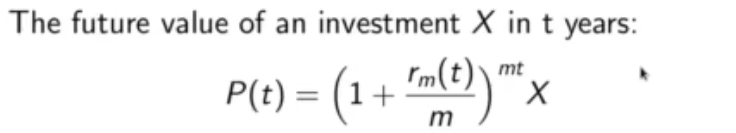



*   P(t) = Future Value
*   m = frequency (m times per year)
*   t = unit is year
*   X = initial investment






In [ ]:
X = 15000
m = 2 # semiannually compounded
r = 0.06
t = 5 # years

P_t = (1 + r / m)**(t*m)*X
P_t # future value of X in the given parameters
print("P(t) for %", X, "m=", m, "r=", r , "t=", t,  "years: ", P_t)


In [ ]:
X = 15000
m = 12 # montly compounded
r = 0.055
t = 5 # years

P_t = (1 + r / m)**(t*m)*X
P_t # future value of X in the given parameters
print("P(t) for %", X, "m=", m, "r=", r , "t=", t,  "years: ", P_t)

In [ ]:
print(calculate_compounded_interest(15000, 2, 0.06, 5))
print(calculate_compounded_interest(15000, 12, 0.055, 5))

#2) Interest rate conversions

**Example**: If the annually compounded interest rate is 5%, what is the corresponding semiannualy compounded interest rate?

In [ ]:
X = 1 # assume initial investment is $1
m = 1 # annually
r = 0.05
t = 1 # assume loan duration is 1 year

X_2 = 1 # same amount
m_2 = 2 # semi annually
r_2 = 0 # unknown
t_2 = 1 # same duration

P_t_1 = calculate_compounded_interest(X, m, r, t)
print(P_t_1)
print(get_equivalent_rate(P_t_1, 1, 2, 1))


#3) Continuous Compounding: TODO


#4) Bonds and Discounted Cash Flow Analysis

## **Example** [1]

Calculate the price of a bond with a $1000 face value which pays annual coupon(interest) of 5%, and which matures in 4 years. Assume the prevailing interest rate (annually compounded) is 6% for all loan terms (flat term structure).

## Given bond information

In [ ]:
coupon_rate = 5/100
t = 4
r = 6/100
face_value = 1000
m = 1 # annually payment

c1 = face_value * coupon_rate # 1 year later
t1 =1

c2 = face_value * coupon_rate # 2 years later
t2 =2

c3 = face_value * coupon_rate # 3 years later
t3 =3

c4 = (face_value * coupon_rate) + face_value # 4 years later
t4 =4



## Calculate present values for each payment

In [ ]:
# initialize bond information.
bond_info = {
    'coupon_value': [c1, c2, c3, c4],
    'time': [t1, t2, t3, t4]
    }

# Create DataFrame
bond_data = pd.DataFrame(bond_info)

# add 'present value' data to dataframe
bond_data["present_value"] = bond_data.apply(lambda row: calculate_present_value(row["coupon_value"], r, m, row["time"]), axis=1)

bond_data

## Barplot of the payments

In [ ]:
# Plot barplot with seaborn for the coupon payments
ax = sns.barplot(data = bond_data, y = "time", x = "coupon_value", orient='h')
ax.bar_label(ax.containers[0]) # TODO: amount' larin onune $ nasil ekleniyor?
ax.set(
    title='Coupon payments',
    xlabel='coupon amount ($)',
    ylabel='payment date (year)'
    )
#ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

#type(ax.containers[0])
## "${:.2f}".format(a)

In [ ]:
bond_data

## Print the bond life cycle

In [ ]:
print_bond_present_value_description(bond_data)

NOTE: Present value of the bond is $965.35

This amount of $965.35 is called DIRTY PRICE since this calculation does not take into account the accured interest!

## Scatter Plot of the present values of the payments

In [ ]:
plt.figure(figsize=(12, 12))

# present value vs future value plot
ax = sns.scatterplot(data=bond_data, x="coupon_value",
                    y="present_value")
ax.set_xlim(0, 1100)
ax.set_xticks(np.arange(start=0, stop=1100, step=50))
ax.set_yticks(np.arange(start=0, stop=900, step=50))



ax.axvline(bond_data.iloc[0]["coupon_value"], color="blue", linestyle="--", label="to be paid in the future")
ax.axvline(bond_data.iloc[3]["coupon_value"], color="blue", linestyle="--")

ax.axhline(bond_data.iloc[0]["present_value"], color="red", linestyle="--", label="present value")
ax.axhline(bond_data.iloc[3]["present_value"], color="red", linestyle="--")

ax.set(
    title='Present vs To be paid values',
    xlabel='To be paid Values ($)',
    ylabel='Present values ($)'
    )
ax.legend(loc="center right")

plt.show()

# TODO: 50 ve 1050' leri x ekseninde nasil isaretleyecegim?
# TODO: PV(50) ve PV(1050)' leri y ekseninde nasil isaretleyecegim?

## Example [2]

PS_CouponBond.pdf

Determine the payments and payment dates of a 5 year bond with a
face value of $50,000 and paying annual coupons of 4%. Plot the payments

In [ ]:
face_value_1 = 50000.0
duration_in_years_1 = 5
coupon_rate_1 = 4/100

b_l = get_bond_lifecycle(face_value= face_value_1, coupon_rate = coupon_rate_1, duration_in_years=duration_in_years_1)

ax = sns.barplot(data = b_l, x="year", y="cash_flow")

ax.set(
    title='Coupon payments',
    xlabel='year',
    ylabel='cash flow amount'
    )

ax.bar_label(ax.containers[0])

plt.show()


## Example [3]

Determine the payments and payment dates of a 4 year bond with a
face value of $20,000 paying 7% coupons semiannually. Plot the payments.

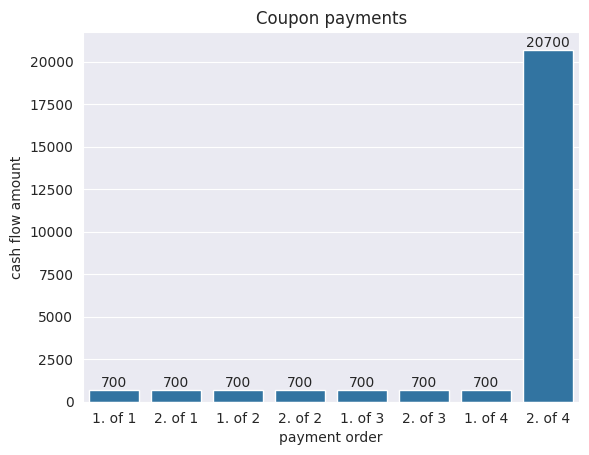

In [165]:
face_value_2 = 20000.0
duration_in_years_2 = 4
coupon_rate_2 = 7/100
requency_per_year_2 = 2

b_l = get_bond_lifecycle_with_frequency(face_value= face_value_2, coupon_rate = coupon_rate_2, duration_in_years=duration_in_years_2, frequency_per_year=requency_per_year_2)

bar_label_list = []

for ind in b_l.index:
  bar_label_list.append(str(b_l.loc[ind, "order_in_year"]) + ". of " + (str(b_l.loc[ind, "year"])  ))

ax = sns.barplot(data = b_l, x=bar_label_list, y="cash_flow")

ax.set(
    title='Coupon payments',
    xlabel='payment order',
    ylabel='cash flow amount'
    )

ax.bar_label(ax.containers[0])
plt.show()


# 5) Present and Future Values of Cash Flow Streams

## Example[1]:
Consider a contract that pays

*   $ 1000  in 1 year,

*   $ 3000  in 2 years,

*   $ 5000  in 4 years.

Suppose the prevailing interest rate for all terms to maturity is 5%.
* [1] What is the future value of this contract at its maturity (in 4 years)? We will invest the money when we receive until the end of the contract.
* [2] How much should we pay to enter into this contract?


In [ ]:
print("[1]")
#[1] What is the future value of this contract at its maturity (in 4 years)?
# We will invest the money when we receive until the end of the contract.

# for $1000 payment: FV = (4-1=3 years of compounding interest) + $1000
FV_1000 = calculate_compounded_interest(X=1000, m=1, r=5/100, t=3)
print("Future value of $1000: ", get_formatted_amout(FV_1000))

# for $3000 payment: FV = (4-2=2 years of compounding interest) + $3000
FV_3000 = calculate_compounded_interest(X=3000, m=1, r=5/100, t=2)
print("Future value of $3000: ", get_formatted_amout(FV_3000))

# for $5000 payment: FV = (4-4=0 years of compounding interest) + $5000
FV_5000 = calculate_compounded_interest(X=5000, m=1, r=5/100, t=0)
print("Future value of $5000: ",get_formatted_amout(FV_5000))

print("Total future value is the sum of each future values: ", get_formatted_amout(FV_1000+FV_3000+FV_5000))
print()

print("[2]")
# [2] How much should we pay to enter into this contract?
# so i need to find the present values of each future value.

# for $1000 payment will be done in 1 year
PV_1000 = calculate_present_value(total_return_amount=1000, m=1, t=1, r=5/100)
print("Present value of $1000 (to be paid in 1 year): ", get_formatted_amout(PV_1000))

# for $3000 payment will be done in 2 year
PV_3000 = calculate_present_value(total_return_amount=3000, m=1, t=2, r=5/100)
print("Present value of $3000 (to be paid in 2 year): ", get_formatted_amout(PV_3000))

# for $5000 payment will be done in 4 year
PV_5000 = calculate_present_value(total_return_amount=5000, m=1, t=4, r=5/100)
print("Present value of $5000 (to be paid in 5 year): ", get_formatted_amout(PV_5000))
print("Total present value is the sum of each present values:", get_formatted_amout(PV_1000 + PV_3000 + PV_5000))


## Example[2]:

Suppose you intend to save

$5000 per year for the next 2 years,

$8000 per year for the next 2 years

after that, and finally $10000 in the fifth year.

If you are earning an interest rate of 4% in your savings account,

how much money will be in your account after 5 years?

In [ ]:
earning_data = {
    "savings": [5000, 5000, 8000, 8000, 10000],
    "when_to_save": [1, 2, 3, 4, 5] # after n year(s)
}

df_earning = pd.DataFrame(data=earning_data)


df_earning["year_in_savings_account"] = 5 - df_earning["when_to_save"]
print(df_earning)

ax = sns.scatterplot(data=df_earning, x = "savings", y="year_in_savings_account")

ax.set(
    title='Year(s) in the savings account vs Savings',
    xlabel='Savings',
    ylabel='Year in the savings account'
    )

plt.show()


In [ ]:

r = 4/100
df_earning["future_value"] = df_earning.apply(lambda row: calculate_compounded_interest(row["savings"], 1, r, row["year_in_savings_account"]), axis=1)
print(df_earning)
print()
print("How much money will be in your account after 5 years?: ", get_formatted_amout(df_earning["future_value"].sum()))


## 6) Coupon Bond Valuation: TODO. Bir tane daha ornek yap.

Fixed Income Analysis With Python Tools for Bonds and Money Market Instruments
24. ders 3.36 sn.

# 7) Bond pricing with Accrued Interest

## 7.1) Dirty (Full) Price and Clean Price

Clean Price = Full Price - Accrued Interest

The Accrued Interest is fraction of the next coupon payment (that has already been "earned").

Accrued Interest = (days elapsed since the last coupon payment) / (number of days betwen coupon payments) * c

* This definition is "rough" because the day count convension is assumed "actual/actual".

## 7.2) Day Count Conventions

Actual/Actual: Actual number of calendar days are used.

## Example (with Actual/Actual)

Suppose a bond maturing on June 15, 2022, with a face value of $100.000 and paying %8 coupons semiannually on June 15 and December 15 every year, is sold on August 15 2020. What is the accured interest using actual/actual day count?

In [ ]:
calendar.monthrange(2024, 9)

calender_data = {
    "month" : np.arange(1, 13, 1),
    "number_of_days" : np.zeros((12,), dtype=int),
    "accrual_days": np.zeros((12,), dtype=int)
}

# create dataframe
calender_df = pd.DataFrame(data = calender_data, columns=["month", "number_of_days", "accrual_days"])

# add number of days for each month
calender_df["number_of_days"] = calender_df.apply(lambda row: calendar.monthrange(2024, row["month"])[1], axis=1 )

last_coupon_payment_date = datetime.datetime(2020, 6, 15)
sold_date = datetime.datetime(2020, 8, 15)
next_coupon_payment_date = datetime.datetime(2020, 12, 15)

calender_df


In [ ]:
# just to show the days in detail

last_payment_month = int(last_coupon_payment_date.strftime("%m"))
last_payment_day = int(last_coupon_payment_date.strftime("%d"))
number_of_days_in_last_payment_month = calender_df.query("month == @last_payment_month")["number_of_days"]

# calender_df.iloc[a, b] --> a:row index, b:column index of the dataframe!
calender_df.iloc[(last_payment_month-1), 2] = number_of_days_in_last_payment_month - last_payment_day

sold_month = int(sold_date.strftime("%m"))
sold_day = int(sold_date.strftime("%d"))

calender_df.iloc[last_payment_month:(sold_month-1), 2] = calender_df.iloc[last_payment_month:(sold_month-1)]["number_of_days"]
calender_df.iloc[(sold_month-1), 2] = sold_day
calender_df

In [ ]:
#last_coupon_payment_date = datetime.datetime(2020, 6, 15)
#sold_date = datetime.datetime(2020, 8, 15)
#next_coupon_payment_date = datetime.datetime(2020, 12, 15)

number_of_days_between_last_coupon_payment_and_sold_date = get_actual_number_of_days_between(sold_date, last_coupon_payment_date).days
print("number_of_days_between_last_coupon_payment_and_sold_date: ", int(number_of_days_between_last_coupon_payment_and_sold_date))

number_of_days_between_coupon_payment_dates = get_actual_number_of_days_between(last_coupon_payment_date, next_coupon_payment_date).days
print("number_of_days_between_coupon_payment_dates: ", int(number_of_days_between_coupon_payment_dates))

bond_face_amount = 100000
coupon_rate = 8/100
payment_frequency_per_year = 2
coupon_amount = coupon_rate * bond_face_amount / payment_frequency_per_year
print("coupon_amount:", get_formatted_amout(coupon_amount))

accured_interest = number_of_days_between_last_coupon_payment_and_sold_date / number_of_days_between_coupon_payment_dates * coupon_amount
print("accured_interest:", get_formatted_amout(accured_interest))

## Example (with actual/actual)
Suppose \$ 1000000 goverment bond, maturing on June 30 2030, and paying 5% coupons annually is trading for $945.000 on September 15 2025. What is the accured interest and flat price on that date using actual/actual day convention.


In [ ]:
matury_date = datetime.datetime(2030, 6, 30)
trade_date = datetime.datetime(2025, 9, 15)
last_payment_date = datetime.datetime(2025, 6, 30)

trade_amount = 945000 # bond price
face_value = 1000000
payment_frequency = 1 # annually
coupon_rate = 5/100

coupon_amount = coupon_rate * face_value / payment_frequency

num_of_days_bet_last_coupon_payment_and_sold_date = get_actual_number_of_days_between(trade_date, last_payment_date).days
print("num_of_days_bet_last_coupon_payment_and_sold_date: ", num_of_days_bet_last_coupon_payment_and_sold_date)
print("number of the days in a year (actual/actual): ", 365)
accrued_interest_amount = num_of_days_bet_last_coupon_payment_and_sold_date / 365 * coupon_amount
print("accrued_interest_amount: ", get_formatted_amout(accrued_interest_amount))

print("flat price = full price - accrued interest")
print("flat price:", get_formatted_amout(trade_amount - accrued_interest_amount))


